# Reference

# Import

In [4]:
import numpy as np 
import pandas as pd 
from operator import add
import warnings
warnings.filterwarnings('ignore')
from scipy import interpolate 
from scipy.signal import chirp, find_peaks, peak_widths, find_peaks_cwt,argrelextrema
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt 
%matplotlib inline 

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.core.sampling import Sampling
from pymoo.core.crossover import Crossover
from pymoo.core.mutation import Mutation

from pymoo.factory import get_termination
from pymoo.termination.default import DefaultMultiObjectiveTermination
from pymoo.termination.xtol import DesignSpaceTermination
from pymoo.termination.robust import RobustTermination
from pymoo.termination.ftol import MultiObjectiveSpaceTermination
from pymoo.termination.ftol import MultiObjectiveSpaceTerminationWithRenormalization

from pymoo.indicators.hv import Hypervolume
from pymoo.util.running_metric import RunningMetricAnimation

from pymoo.visualization.scatter import Scatter
from pymoo.core.callback import Callback
from pymoo.util.display.column import Column
from pymoo.util.display.output import Output
from pymoo.util.plotting import plot

from scipy.interpolate import interp1d

In [5]:
! git clone https://github.com/ChihYuLee/Thin-film-optics-simulation-.git

fatal: destination path 'Thin-film-optics-simulation-' already exists and is not an empty directory.


# Function 

In [6]:
def FWHM(intensities, wavelengths, peakpos):
    

    peak_value= intensities[peakpos]
    phalf= peak_value/2.0
    
    ind1 = peakpos
    ind2 = peakpos  
    
    valuelist= intensities.tolist()
    while ind1>=1 and valuelist[ind1]>phalf:
        ind1=ind1-1
    while ind2<len(valuelist)-1 and valuelist[ind2]>phalf:
        ind2=ind2+1  
        
    return wavelengths[ind2], wavelengths[ind1]

def read_refractive_index_file(materials,min_lambda=300):
    """

    Parameters
    ----------
    materials : Layer of materials are used 
    min_lambda : Minimum wavelength of interest 

    Returns
    -------
    wavelengths: Wavelenths contained in txt file 
    indexes: Different Indexes of n k as a function of wavelengths in amorphous and crystalline states
    (n_crystalline, k_crystalline, n_amorphous, k_amorphous) or (n, k)
    extrapolated: Extrapolated values 

    """
    
    global wavelengths, indexes, extrapolated
    wavelengths=None
    indexes=None
    extrapolated= None
    
    
    if materials== "GST":
        file_data = np.loadtxt("/Thin-film-optics-simulation-/refractive_index_GST_pei.txt", dtype=np.float32)
        wavelengths= file_data[:,0][:,None]
        indexes=file_data[int(min_lambda-wavelengths[0][0]):,1:]
    
    #with max_lambda_interp=1745
    elif materials=="AIST":
        file_data = np.loadtxt("Thin-film-optics-simulation-/refractive_index_AIST.txt", dtype=np.float32)
        wavelengths= file_data[:,0][:,None]
        indexes=file_data[int(min_lambda-wavelengths[0][0]):,1:] # 4 columns 
        
        max_lambda_interp=1745
        extrapolated=np.zeros((max_lambda_interp-min_lambda+1,indexes.shape[1]))
        for i in range(extrapolated.shape[1]):
            f=interpolate.interp1d(wavelengths.flatten(), indexes[:,i], fill_value='extrapolate')
            extrapolated[:,i]= f(np.arange(min_lambda, max_lambda_interp+1))
    
    elif materials== "ITO": 
        file_data = np.loadtxt("Thin-film-optics-simulation-/refractive_index_ITO_Ellipsometry_meausred .txt", dtype=np.float32)
        wavelengths= file_data[:,0][:,None]
        indexes=file_data[int(min_lambda-wavelengths[0][0]):,1:] #only 2 columns 
        indexes=np.tile(indexes, (1, 2))
    
    #Compared with Pei
    elif materials== "Pt":
        file_data = np.loadtxt("Thin-film-optics-simulation-/Pt.txt", dtype=np.float32)
        wavelengths= file_data[:,0][:,None]
        indexes=file_data[int(min_lambda-wavelengths[0][0]):,1:]  #only 2 columns
        indexes=np.tile(indexes, (1, 2))
        
    #Compared with Pei
    elif materials== "Ag":
        file_data = np.loadtxt("Thin-film-optics-simulation-/refractive_index_Ag_Ellipsometry_meausred.txt", dtype=np.float32)
        wavelengths= file_data[:,0][:,None]
        indexes=file_data[int(min_lambda-wavelengths[0][0]):,1:]  #only 2 columns
        indexes=np.tile(indexes, (1, 2))
        
    #Longer Spectrum with max_lambda_interp=10000
    elif materials== "Ag2":
        file_data = np.loadtxt("Thin-film-optics-simulation-/refractive_index_Ag_long.txt", dtype=np.float32)
        wavelengths= file_data[:,0][:,None]
        indexes=file_data[:,1:]  #only 2 columns
        indexes=np.tile(indexes, (1, 2))
        
        max_lambda_interp=10000
        extrapolated=np.zeros((max_lambda_interp-min_lambda+1,indexes.shape[1]))
        for i in range(extrapolated.shape[1]):
            f=interpolate.interp1d(wavelengths.flatten(), indexes[:,i], fill_value='extrapolate')
            extrapolated[:,i]= f(np.arange(min_lambda, max_lambda_interp+1))
        
    #Compared with Pei 
    elif materials== "SiO2":
        file_data = np.loadtxt("Thin-film-optics-simulation-/refractive_index_SiO2_Lemarchand 2013_Thin Film.txt", dtype=np.float32)
        wavelengths= file_data[:,0][:,None]
        indexes=file_data[int(min_lambda-wavelengths[0][0]):,1:]  #only 2 columns
        indexes=np.tile(indexes, (1, 2))
        
    elif materials== "Ge":
        file_data = np.loadtxt("Thin-film-optics-simulation-/refractive_index_Ge.txt", dtype=np.float32)
        wavelengths= file_data[:,0][:,None]
        indexes=file_data[int(min_lambda-wavelengths[0][0]):,1:]  #only 2 columns
        indexes=np.tile(indexes, (1, 2))
        
    elif materials== "TiO2":
        file_data = np.loadtxt("Thin-film-optics-simulation-/refractive_index_TiO2.txt", dtype=np.float32)
        wavelengths= file_data[:,0][:,None]
        indexes=file_data[int(min_lambda-wavelengths[0][0]):,1:]  #only 2 columns
        indexes=np.tile(indexes, (1, 2))
    
    elif materials== "SbSe":
      #10 nm or 15 nm (Si) or 20 nm 
        file_data = np.loadtxt("Thin-film-optics-simulation-/refractive_index_SbSe_Ellipsometry_meausred_20nm.txt", dtype=np.float32)
        wavelengths= file_data[:,0][:,None]
        indexes=file_data[int(min_lambda-wavelengths[0][0]):,1:]  #4 columns
     

    return wavelengths, indexes, extrapolated


def transfer_matrix_trans(theta0, n0, max_lambda, min_lambda, number_layers, n, k, d, pol):
    
    """
    Parameters
    ------
    theta0 : Incident angle in degrees
    n0 : Refraction index of incident medium 
    max_lambda : Maximum lambda to run simulation / Beware: some materials n and k are given up to 800nm
    min_lambda : Minimum lambda to run simulation
    number_layers :  Total number of layers (without counting air)
    n : Refractive index n of crystalline or amorphous states, shape= (wavelengths,layers) #(500,5)
    k : Refractive index k of crystalline or amorphous states = (wavelengths, layers)#(500,5)
    d : Layers of thickness
    pol : Choose either TE or TM polarization (relevant under oblique incidence)


    Returns
    -------
    #array containing X, A, R, T, Phi, Psi
    X: wavelengths in nm 
    A: Apsorption 
    R: Reflection
    T: Transmittance 
    Phi: Phase difference of R in stack of layers 
    Psi: Phase difference of T in stack of layers 
    
    """
    # Parameters for calculation 
    matrix_lambda= max_lambda-min_lambda
    admitanceinvacuum=2.6544*10**(-3)
    m= np.array([[1,0],[0,1]],dtype=complex)
    y=np.empty((matrix_lambda+1, number_layers),dtype=complex)
    eta= np.empty((matrix_lambda+1, number_layers),dtype=complex)
    theta= np.empty((matrix_lambda+1, number_layers),dtype=complex)
    delta= np.empty((matrix_lambda+1, number_layers-1),dtype=complex)

    
    
    # First layer (PCM)---> theta1, eta1, y1
    theta1= np.arcsin(np.divide(n0*np.sin(theta0),(n[:,0]-1j*k[:,0])))
    y0=n0*admitanceinvacuum 
    y1= (n[:,0]-1j*k[:,0])*admitanceinvacuum 
    if pol=='TE':
        eta0= y0*np.cos(theta0)
        eta1= y1*np.cos(theta1)
    elif pol=='TM':
        eta0= y0/np.cos(theta0)
        eta1= y1/np.cos(theta1)
    else:
        print('Ther is an error')
 
    y[:,0]=y1
    eta[:,0]=eta1
    theta[:,0]=theta1
    M=np.empty((2,2,matrix_lambda+1), dtype=complex)
    for j in range(matrix_lambda+1):
        M[:,:,j]= m
    
    
    
    # Rest of layers 
    lambda_complete= np.arange(min_lambda, max_lambda+1)*10**(-9)
    A=np.empty(matrix_lambda+1)
    R=np.empty(matrix_lambda+1)
    T=np.empty(matrix_lambda+1)
    Phi=np.empty(matrix_lambda+1)
    Psi=np.empty(matrix_lambda+1)
  
        

    
    for i in range(number_layers-1): #different layers
        
        theta[:,i+1]= np.arcsin(np.divide(n[:,i]*np.sin(theta[:,i]), (n[:,i+1]-1j*k[:,i+1])))
        y[:,i+1]=(n[:,i+1]-1j*k[:,i+1])*admitanceinvacuum
        
        if pol=='TE':
            eta[:,i+1]= y[:,i+1]*np.cos(theta[:,i+1])
        elif pol=='TM':
            eta[:,i+1]= y[:,i+1]/np.cos(theta[:,i+1])
        else:
            print('Ther is an error')
        

        delta[:,i]=2*np.pi*d[i]*np.sqrt(n[:,i]**2
                                        -k[:,i]**2
                                        -n0*(np.sin(theta0))**2
                                        -2j*(n[:,i]*k[:,i]))/lambda_complete
        
        s= np.array([[np.cos(delta[:,i]),1j*np.sin(delta[:,i])/eta[:,i]]
                     ,[1j*eta[:,i]*np.sin(delta[:,i]),np.cos(delta[:,i])]], 
                    dtype= complex)


        
        for j in range(s.shape[-1]): #different wavelengths
            M[:,:,j]= M[:,:,j]@s[:,:,j]
            

    #Outputs       
    MM= np.empty((s.shape[0],s.shape[-1]), complex)
    for j in range(s.shape[-1]):  #different wavelengths
        MM[:,j]= M[:,:,j]@ np.array([1,eta[j][-1]], dtype=complex)
        
    B=MM[0,:]
    C=MM[1,:]
    Y=C/B
    r0= np.divide((eta0-Y),(eta0+Y))
    
    R= r0*np.conj(r0)
    T= np.divide(4*eta0*np.real(eta[:,-1]),(eta0*B+C)*np.conj(eta0*B+C))
    A= np.divide(4*eta0*np.real(B*np.conj(C)-eta[:,-1]),(eta0*B+C)*np.conj(eta0*B+C))
    Phi= np.arctan(np.divide(np.imag(eta[:,-1]*(B*np.conj(C)-C*np.conj(B))),
                   np.real((eta[:,-1])**2)*B*np.conj(B)-C*np.conj(C)))
    Psi= np.arctan(np.divide( -np.imag(eta0*B+C),np.real(eta0*B+C)))
    X= lambda_complete
    output= np.array([X, A, R, T, Phi, Psi])
    
    return output

def input_parameters(PCM, Ag1, ITO, Ag2, plot=True, results_return=False, max_lambda=749, shrinkage=1):
    ############### Parameters ################
    theta_inc=0       ##Incident angle in degrees
    number_layers=5   ##Total number of layers (without counting air)
    min_lambda=350    ##Minimum lambda to run simulation
    max_lambda= max_lambda ##Maximum lambda to run simulation
    shrinkage= shrinkage #Shrinkage
    n0=1              ##refraction index of incident medium
    pol='TE'          ##Choose either TE or TM polarization (relevant under oblique incidence)
    pcm='SbSe'        ##Chose the PCM materials 
    d_PCM= PCM #float(input('PCM thickness:'))     
    d_Ag1= Ag1 #float(input('Ag1 thickness:'))    
    d_ITO= ITO #float(input('ITO thickness:')) 
    d_Ag2= Ag2 #float(input('Ag2 thickness:'))
    d_air=1000                            ##Thickness of Air 



    ############### Import all the refractive idexes from the files #############
    # Order from top to bottom 
    stack_layers=[pcm,'Ag','ITO','Ag','Air']
    stack_thickness_amo=[d_PCM, d_Ag1, d_ITO, d_Ag2, d_air] 
    stack_thickness_cry=[shrinkage*d_PCM, d_Ag1, d_ITO, d_Ag2, d_air]
    stack_thickness_nm_amo=[i *1e-9 for i in stack_thickness_amo]
    stack_thickness_nm_cry= [i *1e-9 for i in stack_thickness_cry]
    n_crystalline=np.zeros((max_lambda-min_lambda+1, number_layers))  
    k_crystalline=np.zeros((max_lambda-min_lambda+1, number_layers))  
    n_amorphous=np.zeros((max_lambda-min_lambda+1, number_layers))    
    k_amorphous=np.zeros((max_lambda-min_lambda+1, number_layers))    

    for i,l in enumerate(stack_layers):

        #materials layer 
        if i is not len(stack_layers)-1:
            n_crystalline[:,i]= read_refractive_index_file(l,min_lambda)[1][:max_lambda-min_lambda+1,0]
            k_crystalline[:,i]= read_refractive_index_file(l,min_lambda)[1][:max_lambda-min_lambda+1,1]
            n_amorphous[:,i]= read_refractive_index_file(l,min_lambda)[1][:max_lambda-min_lambda+1,2]
            k_amorphous[:,i]= read_refractive_index_file(l,min_lambda)[1][:max_lambda-min_lambda+1,3]
        #Air layer
        else:
            n_crystalline[:,i]= np.ones(max_lambda-min_lambda+1)
            k_crystalline[:,i]= np.zeros(max_lambda-min_lambda+1)
            n_amorphous[:,i]= np.ones(max_lambda-min_lambda+1)
            k_amorphous[:,i]= np.zeros(max_lambda-min_lambda+1)

      ############## Transfer Matrix Calculations ##################
      #incident angle in radians
    theta0= theta_inc*np.pi/180 
      #array containing X, A, R, T, Phi, Psi
    results_c= transfer_matrix_trans(theta0, n0, max_lambda, min_lambda, number_layers
                                     , n_crystalline, k_crystalline, stack_thickness_nm_cry, pol)
    results_a= transfer_matrix_trans(theta0, n0, max_lambda, min_lambda, number_layers
                                     , n_amorphous, k_amorphous, stack_thickness_nm_amo, pol)

    ######## Calculation on Output ################
    x= (results_a[0, :]/1e-9)
    materials= zip(stack_layers, stack_thickness_amo)
    max_r= np.real(np.max(results_c[2,:]))
    max_r_index= np.where(results_c[2,:]==max_r)

    ######### Plot Response ###############
    plt.figure(figsize = (12,8))
    plt.title(list(materials))
    plt.xlabel('Wavelength(nm)')
    plt.ylabel('Intensity')
    #plt.ylim(-1,1)
    plt.plot(x,np.zeros(x.shape[0]),'-',c='black',lw=1)
    plt.plot(x, results_c[2,:],'-', c='blue', label='$R_{cry}$')
    plt.plot(x, results_c[3,:],'--',c= 'red', label='$T_{cry}$')
    plt.plot(x, results_a[2,:],'-', c='yellow', label='$R_{amo}$')
    plt.plot(x, results_a[3,:],'--',c= 'purple', label='$T_{amo}$')
    #plt.plot(x, -(results_c[-2,:]-results_a[-2,:])/(np.pi*2),'-', c='green', label='$\phi_{R}$' ) #Negative sign or not 
    #plt.plot(x, -(results_c[-1,:]-results_a[-1,:])/(np.pi*2),'--', c='c', label='$\psi_{T}$' ) #Negative sign or not 
    #plt.scatter(x, -(results_c[-2,:]-results_a[-1,:])/(np.pi*2),'--', c='c' )
    
    #######Plot FWHM #############
    spec=results_a[3,:]

    peaks, _ = find_peaks(spec)
    #results_half = peak_widths(spec, peaks, rel_height=0.5)
    #plt.hlines(results_half[1],results_half[2]+min_lambda, results_half[3]+min_lambda , color="purple", label='')
    max_peak_intensity= np.max(spec[peaks]) #Intensity of highest peak 
    max_peak_loc_in_peaks= np.argmax(spec[peaks]) #Location of highest peak in peaks 
    max_peak_loc_in_total= peaks[max_peak_loc_in_peaks] #Location of highest peak entire spectrum 
    max_peak_lambda= np.real(x[max_peak_loc_in_total])#Wavelength of highest peak 
    
    print('Amorphus Transmission:', peaks)
    print('Max Peak Lambda Transmission:', max_peak_lambda)
    
    """
    intensity_for_fwhm= np.zeros_like(spec)
    for i in range(intensity_for_fwhm.shape[0]):
        if  max_peak_loc_in_total-100<i<max_peak_loc_in_total+100:
            intensity_for_fwhm[i]=spec[i]
    """
    intensity_for_fwhm= spec
    fwhm2, fwhm1= FWHM(intensity_for_fwhm,x, max_peak_loc_in_total)

    if peaks.shape[0]!=0:
        plt.hlines(max_peak_intensity/2.0, fwhm1, fwhm2, color="purple", label='$FWHM_{amo}$')
    
    peaks_a= spec[peaks]
    fwhm_a= fwhm2-fwhm1
    wavelength_a= x[peaks]
    
    spec=results_c[3,:]
    peaks, _ = find_peaks(spec)
    #results_half = peak_widths(spec, peaks, rel_height=0.5)
    #plt.hlines(results_half[1],results_half[2]+min_lambda, results_half[3]+min_lambda , color="red")
    max_peak_intensity= np.max(spec[peaks]) #Intensity of highest peak 
    max_peak_loc_in_peaks= np.argmax(spec[peaks]) #Location of highest peak in peaks 
    max_peak_loc_in_total= peaks[max_peak_loc_in_peaks] #Location of highest peak entire spectrum 
    max_peak_lambda= np.real(x[max_peak_loc_in_total]) #Wavelength of highest peak 

    intensity_for_fwhm= spec
    fwhm2, fwhm1= FWHM(intensity_for_fwhm,x, max_peak_loc_in_total)
    if peaks.shape[0]!=0:
        plt.hlines(max_peak_intensity/2.0, fwhm1, fwhm2, color="red", label='$FWHM_{cry}$')
    
    peaks_c= spec[peaks]
    fwhm_c= fwhm2-fwhm1
    wavelength_c= x[peaks]
    
    plt.legend()
    plt.show()
    
    ############### Crystalline for FROC ###################
    spec= results_a[2,:]
    peaks, _ = find_peaks(spec)
    if peaks.shape[0]!=0:
        max_peak_intensity= np.max(spec[peaks])
        max_peak_loc_in_peaks= np.argmax(spec[peaks])
        max_peak_loc_in_total= peaks[max_peak_loc_in_peaks] #Location of highest peak entire spectrum 
        max_peak_lambda= np.real(x[max_peak_loc_in_total])#Wavelength of highest peak 
        
    else:
        max_peak_lambda=None
    print('Amorphus Reflection:', peaks)
    print('Max Peak Lambda Relection:', max_peak_lambda)
    print('----------')
    
    if results_return==True:
        return peaks_a, fwhm_a, peaks_c, fwhm_c,wavelength_a, wavelength_c, results_a[2,:], results_c[2,:],results_a[3,:],results_c[3,:]

# Test 

Amorphus Transmission: [ 57 361]
Max Peak Lambda Transmission: 711.0


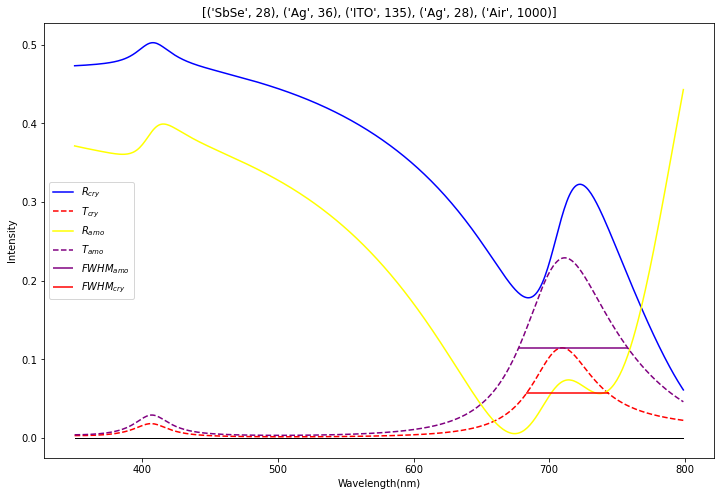

Amorphus Reflection: [ 65 364]
Max Peak Lambda Relection: 415.0
----------
Amorhous peak: [0.02922538 0.22904338]
Amorphous FWHM: 81.0
Amorphpus peak loc: [407. 711.]
Crystalline peak: [0.01831236 0.11469171]
Crystalline FWHM: 61.0
Crystalline peak loc: [406. 710.]


In [7]:
a, b, c, d, e,f,g,h, i,j  = input_parameters(28, 36, 135, 28 , plot=True, 
                                             results_return=True,max_lambda=799, shrinkage=0.76)

print('Amorhous peak:',np.real(a))
print('Amorphous FWHM:',np.real(b))
print('Amorphpus peak loc:', np.real(e))
print('Crystalline peak:',np.real(c))
print('Crystalline FWHM:',np.real(d))
print('Crystalline peak loc:', np.real(f))

# Objective function 

In [9]:
def find_peak_FWHM_loc(a, b, c, d, metric='T', target='amorphous', 
                       max_lambda= 749, shrinkage= 1, limit_region= False, focus_peak= None): 
     ############### Parameters ################
    theta_inc=0       ##Incident angle in degrees
    number_layers=5   ##Total number of layers (without counting air)
    min_lambda=350    ##Minimum lambda to run simulation
    max_lambda=max_lambda   ##Maximum lambda to run simulation
    n0=1              ##refraction index of incident medium
    pol='TE'          ##Choose either TE or TM polarization (relevant under oblique incidence)
    pcm='SbSe'  ##Chose the PCM materials 
    shrinkage= shrinkage
    

    d_PCM= a
    d_Ag1= b   
    d_ITO= c
    d_Ag2= d
    d_air=1000                

    stack_layers=[pcm,'Ag','ITO','Ag','Air']
    stack_thickness_amo=[d_PCM, d_Ag1, d_ITO, d_Ag2, d_air] 
    stack_thickness_cry=[shrinkage*d_PCM, d_Ag1, d_ITO, d_Ag2, d_air]
    stack_thickness_nm_amo=[i *1e-9 for i in stack_thickness_amo]
    stack_thickness_nm_cry= [i *1e-9 for i in stack_thickness_cry]
    
    n_crystalline=np.zeros((max_lambda-min_lambda+1, number_layers))  
    k_crystalline=np.zeros((max_lambda-min_lambda+1, number_layers))  
    n_amorphous=np.zeros((max_lambda-min_lambda+1, number_layers))    
    k_amorphous=np.zeros((max_lambda-min_lambda+1, number_layers)) 


    ############### Import Data #################
    for i,l in enumerate(stack_layers):
      
    #materials layer 
      if i is not len(stack_layers)-1:
        n_crystalline[:,i]= read_refractive_index_file(l,min_lambda)[1][:max_lambda-min_lambda+1,0]
        k_crystalline[:,i]= read_refractive_index_file(l,min_lambda)[1][:max_lambda-min_lambda+1,1]
        n_amorphous[:,i]= read_refractive_index_file(l,min_lambda)[1][:max_lambda-min_lambda+1,2]
        k_amorphous[:,i]= read_refractive_index_file(l,min_lambda)[1][:max_lambda-min_lambda+1,3]
    #Air layer
      else:
        n_crystalline[:,i]= np.ones(max_lambda-min_lambda+1)
        k_crystalline[:,i]= np.zeros(max_lambda-min_lambda+1)
        n_amorphous[:,i]= np.ones(max_lambda-min_lambda+1)
        k_amorphous[:,i]= np.zeros(max_lambda-min_lambda+1)

    ############## Transfer Matrix Calculations ##################
    
    #incident angle in radians
    theta0= theta_inc*np.pi/180 
    #array containing X, A, R, T, Phi, Psi
    results_c= transfer_matrix_trans(theta0, n0, max_lambda, min_lambda, 
                                     number_layers, n_crystalline, k_crystalline, stack_thickness_nm_cry, pol)
    results_a= transfer_matrix_trans(theta0, n0, max_lambda, min_lambda, 
                                     number_layers, n_amorphous, k_amorphous, stack_thickness_nm_amo, pol)
    
    if metric=='T':
        #target amorphous transmission
        if limit_region== False:
            if target =='amorphous':
                intensity= np.absolute(np.real(results_a[3,:]))
                wavelengths= np.arange(min_lambda,max_lambda+1,1)
                peaks, _ = find_peaks(intensity)

                if peaks.shape[0]!=0:
                    max_peak_intensity= np.max(intensity[peaks]) #Intensity of highest peak 
                    max_peak_loc_in_peaks= np.argmax(intensity[peaks]) #Location of highest peak in peaks 
                    max_peak_loc_in_total= peaks[max_peak_loc_in_peaks] #Location of highest peak entire spectrum 
                    max_peak_lambda= wavelengths[max_peak_loc_in_total] #Wavelength of highest peak 
                    fwhm2, fwhm1= FWHM(intensity,wavelengths, max_peak_loc_in_total)
                    fwhm= fwhm2- fwhm1
                    ans_touch_side= find_side_touch(min_lambda, max_lambda, fwhm1, fwhm2)
                else:
                    max_peak_intensity=0
                    fwhm=np.inf
                    max_peak_lambda=0
                    ans_touch_side= -np.inf

            else: 
                intensity= np.absolute(np.real(results_c[3,:]))
                wavelengths= np.arange(min_lambda,max_lambda+1,1)
                peaks, _ = find_peaks(intensity)
                if peaks.shape[0]!=0:
                    max_peak_intensity= np.max(intensity[peaks]) 
                    max_peak_loc_in_peaks= np.argmax(intensity[peaks]) 
                    max_peak_loc_in_total= peaks[max_peak_loc_in_peaks]
                    max_peak_lambda= wavelengths[max_peak_loc_in_total]
                    fwhm2, fwhm1= FWHM(intensity,wavelengths, max_peak_loc_in_total)
                    fwhm= fwhm2-fwhm1
                    ans_touch_side= find_side_touch(min_lambda, max_lambda, fwhm1, fwhm2)
                else:
                    max_peak_intensity=0
                    fwhm=np.inf
                    max_peak_lambda=0
                    ans_touch_side= -np.inf
        else:
            wavelengths= np.arange(min_lambda,max_lambda+1,1)
            results_c= transfer_matrix_trans(theta0, n0, max_lambda, min_lambda, number_layers,
                                             n_crystalline, k_crystalline, stack_thickness_nm_cry, pol)
            results_a= transfer_matrix_trans(theta0, n0, max_lambda, min_lambda, number_layers,
                                             n_amorphous, k_amorphous, stack_thickness_nm_amo, pol)

            if target =='amorphous':
                intensity= np.absolute(np.real(results_a[3,:]))
                peaks= np.where(wavelengths==focus_peak)[0]
                max_peak_intensity= intensity[peaks][0]
                max_peak_lambda= focus_peak
                fwhm2, fwhm1= FWHM(intensity, wavelengths, int(peaks))
                fwhm= fwhm2- fwhm1
                ans_touch_side= find_side_touch(min_lambda, max_lambda, fwhm1, fwhm2)

            else:
                intensity= np.absolute(np.real(results_c[3,:]))
                peaks= np.where(wavelengths==focus_peak)[0]
                max_peak_intensity= intensity[peaks][0]
                max_peak_lambda= focus_peak
                fwhm2, fwhm1= FWHM(intensity, wavelengths, int(peaks))
                fwhm= fwhm2- fwhm1
                ans_touch_side= find_side_touch(min_lambda, max_lambda, fwhm1, fwhm2)
                
        return max_peak_intensity, fwhm, max_peak_lambda, ans_touch_side
    
    else:
        
        #target amorphous reflection
        if target =='amorphous':
            reflection= np.absolute(np.real(results_a[2,:]))
            peak_transmission= focus_peak
            wavelengths= np.arange(min_lambda,max_lambda+1,1)
            ans= find_neighbors(reflection, wavelengths, peak_transmission)
            
        else:
            reflection= np.absolute(np.real(results_c[2,:]))
            peak_transmission= focus_peak
            wavelengths= np.arange(min_lambda,max_lambda+1,1)
            ans= find_neighbors(reflection, wavelengths, peak_transmission)

    return ans

def find_neighbors(reflection, wavelengths, peak_transmission):
    
    peak_index_reflection= argrelextrema(reflection, np.greater)
    peak_index_reflection= peak_index_reflection[0]

    
    valley_index_reflection= argrelextrema(reflection, np.less)
    valley_index_reflection= valley_index_reflection[0]
    
    peak_x=peak_index_reflection+wavelengths[0]
    valley_x= valley_index_reflection+wavelengths[0]
    
    #Peak first valley follows 
    together= np.concatenate((peak_x, valley_x))
    distance= np.absolute(together-peak_transmission)
    
    if distance.shape[0]!=0: 
        neighbor= np.argmin(distance)
        #print('Peak:', peak_x, 'Valley:', valley_x, together, distance, neighbor)
        if neighbor> peak_x.shape[0]-1:
            return -np.inf  
        else:
            return 1 
    
    else:
        return -np.inf
    
def find_side_touch(min_wavelength, max_wavelength, fwhm1, fwhm2):
    #print(min_wavelength, max_wavelength, fwhm1, fwhm2)
    ans= 1
    if fwhm1 == min_wavelength:
        ans= -np.inf
    if fwhm2 == max_wavelength:
        ans= -np.inf
    return ans 

# Genetic Algorithm

In [10]:
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=4,
                         n_obj=2,
                         n_constr=6,
                         xl=np.array([1,1,1,1]),
                         xu=np.array([150,50,150,50]))

    def _evaluate(self, x, out, *args, **kwargs):
        
        #parameters
        out['X']=[x[0], x[1], x[2], x[3]]
        
        
        
        #objectives
        
        #Transmission Amorphous 
        max_peak_intensity_a, FWHM_a , max_peak_lambda_a,ans_touch_side_a= find_peak_FWHM_loc(x[0], x[1], x[2], x[3], metric='T',
                                                                             target='amorphous', 
                                                                             max_lambda=749, shrinkage=0.76)
        #Max (peak) amorphous
        f1= -max_peak_intensity_a 
        
        a=x[0]
        b=x[1]
        c=x[2]
        d=x[3]
        
        if 700<max_peak_lambda_a<750:
            max_peak_intensity_a, real_FWHM_a , max_peak_lambda_a,ans_touch_side_a= find_peak_FWHM_loc(a, b, c,d, metric='T',
                                                                            target='amorphous', 
                                                                            max_lambda=799, shrinkage=0.76, 
                                                                            limit_region=True, focus_peak=max_peak_lambda_a)
            
            f2 = real_FWHM_a #Min (FWHM) amorphous
        else:
            f2 = FWHM_a #Min (FWHM) amorphous
            
            
        #Transmission Crystalline 
        max_peak_intensity_c, FWHM_c , max_peak_lambda_c, ans_touch_side_c= find_peak_FWHM_loc(a,b,c,d, metric='T',
                                                                             target='crystalline', 
        
                                                                                               max_lambda=749, shrinkage=0.76)
        #Max (peak) amorphous
        f3= -max_peak_intensity_c 

        
        if 700<max_peak_lambda_c<750:
            max_peak_intensity_c, real_FWHM_c , max_peak_lambda_c, ans_touch_side_c= find_peak_FWHM_loc(a, b, c,d, metric='T',
                                                                            target='crystalline', 
                                                                            max_lambda=799, shrinkage=0.76, 
                                                                            limit_region= True, focus_peak= max_peak_lambda_c)
            f4= real_FWHM_c
        else:
            f4= FWHM_c
            
        f5= -np.abs(max_peak_lambda_a-max_peak_lambda_c)
        
        out["F"] = [f1, f2]
        
        
        #Reflection Amorphous 
        froc_answer_amo= find_peak_FWHM_loc(a, b, c, d, metric='R', 
                                     target='amorphous', max_lambda= 799, 
                                            shrinkage= 0.76, limit_region= True, focus_peak= max_peak_lambda_a)
        
        #Reflection Crystalline 
        froc_answer_cry= find_peak_FWHM_loc(a, b, c, d, metric='R', 
                                     target='crystalline', max_lambda= 799, 
                                            shrinkage= 0.76, limit_region= True, focus_peak= max_peak_lambda_a)
        
        
        #Constraints
        g10= -(max_peak_lambda_a-716)/716
        g11= (max_peak_lambda_a-718)/718
        g12= -(froc_answer_amo-1)/1 #Froc amo 
        g13= -(froc_answer_cry-1)/1 #Froc cry 
        g14= -(ans_touch_side_a-1)/1 #Not exceeding boundaries for fwhm amo 
        g15= -(ans_touch_side_c-1)/1 #Not exceeding boundaries for fwhm cry 

        
        out["G"]=[g10, g11, g12, g13, g14, g15]
        
        r1= max_peak_intensity_a
        r2= f2
        r3= max_peak_lambda_a
        r4= max_peak_intensity_c
        r5= f4
        r6= max_peak_lambda_c
        r7= froc_answer_amo
        r8= froc_answer_cry
        r9= ans_touch_side_a
        r10= ans_touch_side_c
        
        out['R']= [r1, r2, r3, r4, r5, r6, r7, r8, r9, r10]


class MyOutput(Output):

    def __init__(self):
        super().__init__()
        self.f1 = Column("Intensity(AMO)", width=20)
        self.f2 = Column("FWHM(AMO)", width=20)
        self.columns += [self.f1, self.f2]


    def update(self, algorithm):
        super().update(algorithm)
        res1=algorithm.pop.get("F")
        self.f1.set(-np.mean(res1[:,0]))
        self.f2.set(np.mean(res1[:,1]))

problem = MyProblem()

In [ ]:
######################### Algorithm ##################
algorithm = NSGA2(pop_size=500,
                  sampling=IntegerRandomSampling(),
                  crossover=SBX(prob=0.8, eta=2.0, vtype=float, repair=RoundingRepair()),
                  mutation=PM(prob=0.8, eta=2.0, vtype=float, repair=RoundingRepair()),
                  eliminate_duplicates=True)

##################### Termination #####################
termination = get_termination("n_gen", 30)


################### Run ###########################
res = minimize(problem,
               algorithm,
               termination,
               penalty=10000.0, 
               seed=2,
               save_history=True,
               output=MyOutput(),
               verbose=True)


n_gen  |  n_eval  |    Intensity(AMO)    |      FWHM(AMO)      
     1 |      500 |  0.06305054623361701 |                  INF
     2 |     1000 |  0.07649234632858361 |                  INF
     3 |     1500 |  0.07881550563398701 |                  INF
     4 |     2000 |  0.08212341126361233 |                  INF


In [ ]:
############# Simple Convergence #################
n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])

intensity= [0]
fmhw= [1]
plt.title("Convergence of Intensity")
plt.plot(n_evals, -opt[:,intensity], "--")
plt.show()
plt.title("Convergence of FWHM")
plt.plot(n_evals, opt[:,fmhw], "--")
plt.show()


################### Data #######################
hist = res.history
print('No.of Iteration:', len(hist))

n_evals = []             # corresponding number of function evaluations\
hist_cv = []             # constraint violation in each generation
hist_cv_avg = []         # average constraint violation in the whole population
hist_F = []              # the objective space values in each generation
hist_X=[]                # the parameters in each generation 
hist_R=[]                # the data history in each generation  



for algo in hist:

    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algo.opt  #method of an object 

    # store the least contraint violation and the average in each population
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())

    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])
    hist_X.append(opt.get('X')[feas])
    hist_R.append(opt.get('R')[feas])
    



############ Feasible Solutions #########
vals = hist_cv_avg
k = np.where(np.array(vals) <= 0.0)[0].min()
print(f"Whole population feasible in Generation {k} after {n_evals[k]} evaluations.")

plt.figure(figsize=(7, 5))
plt.plot(n_evals, vals,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, vals,  facecolor="none", edgecolor='black', marker="p")
plt.axvline(n_evals[k], color="red", label="All Feasible", linestyle="--")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Constraints Violation")
plt.legend()
plt.show()


In [ ]:
########## Objective Space ############

X, F, R = res.opt.get("X", "F","R")
plt.figure(figsize=(10, 10))
plt.subplot(1,1,1)
num= np.arange(0,X.shape[0],1)
plt.scatter(np.absolute(R[:, 0]), R[:, 1], s=70, c= R[:, 2], marker='*',  label='Amorphous')
for i in range(num.shape[0]):
    plt.text(np.absolute(R[i, 0]), R[i, 1], str(i), fontsize=8, color='purple')
    
plt.scatter(np.absolute(R[:, 3]), R[:, 4], s=70, c=R[:,5], marker='.',label='Crystalline')
for i in range(num.shape[0]):
    plt.text(np.absolute(R[i, 3]), R[i, 4], str(i), fontsize=8, color='red')
    
plt.xlabel('Peak Intensity')
#plt.xlim(right=0.5)
#plt.ylim(top=120)
plt.ylabel('FWHM ')
plt.title("Objective Space ")
leg= plt.legend()
leg.legendHandles[0].set_color('purple')
#leg.legendHandles[1].set_color('red')
clb= plt.colorbar()
clb.ax.set_title("Peak's wavelength")


########## Variable Space ############
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
n, bins, patches =plt.hist(X[:,0])

plt.title('SbSe thickness')
plt.xlabel('nm')

plt.subplot(2,2,2)
plt.hist(X[:,1])
plt.title('Ag1 thickness')
plt.xlabel('nm')

plt.subplot(2,2,3)
plt.hist(X[:,2])
plt.title('ITO thickness')
plt.xlabel('nm')

plt.subplot(2,2,4)
plt.hist(X[:,3])
plt.title('Ag2 thickness')
plt.xlabel('nm')